# Analysis of the model parameters estimate I
Here we analyze the model parameters estimate from the chosen model, i.e., model with seed 66. In the model sensitivity analysis, we initialized the algorithm for 50 random inputs and chose the one with highest expected log-likelihood predictive density on full data. 

+ Data visual summary  
+ Fitted model validity: Numerical measure

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
import os

# 🔥 Fix: Add utils/ directory where vb_stan.py and sub_fun.py are located
sys.path.append("../utils")  # Ensure utils is in module search path

import vb_stan as vbfun
import sub_fun as sf

# import ./data_file.py file from current directory
try:
    from data_file import *
except ModuleNotFoundError as e:
    print(f"❌ Could not import data_file as module, trying another way...")
    try:
        exec(open('./data_file.py').read())  # Execute the script
    except Exception as e:
        print(f"❌ Could not import data_file.py")


import os

# 1. Read config_mode.txt
config_file = "config_mode.txt"
if os.path.exists(config_file):
    with open(config_file, "r") as f:
        lines = f.read().splitlines()
        data = lines[0].strip() if len(lines) > 0 else "original"
        setting = int(lines[1]) if len(lines) > 1 else 1
else:
    data = "original"
    setting = 1

# 2. Set plots folder based on config
if data == "original" and setting == 1: 
    figfol = "./plots1/"
elif data == "original" and setting == 2:
    figfol = "./plots2/"
elif data == "new" and setting == 2: 
    figfol = "./plots3/"

if not os.path.exists(figfol):
    os.makedirs(figfol)
    print(f"✅ Created folder: {figfol}")
else:
    print(f"📂 Folder already exists: {figfol}")

# Update plot settings
plt.rcParams.update(plt.rcParamsDefault)
params = {
    'legend.fontsize': 12,
    'font.weight': 'bold',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'figure.dpi': 200,
    'ytick.labelsize': 12
}
plt.rcParams.update(params)

%matplotlib inline


/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


📂 Folder already exists: ./plots1


### Data visual summary 
Load input and output data for the analysis.

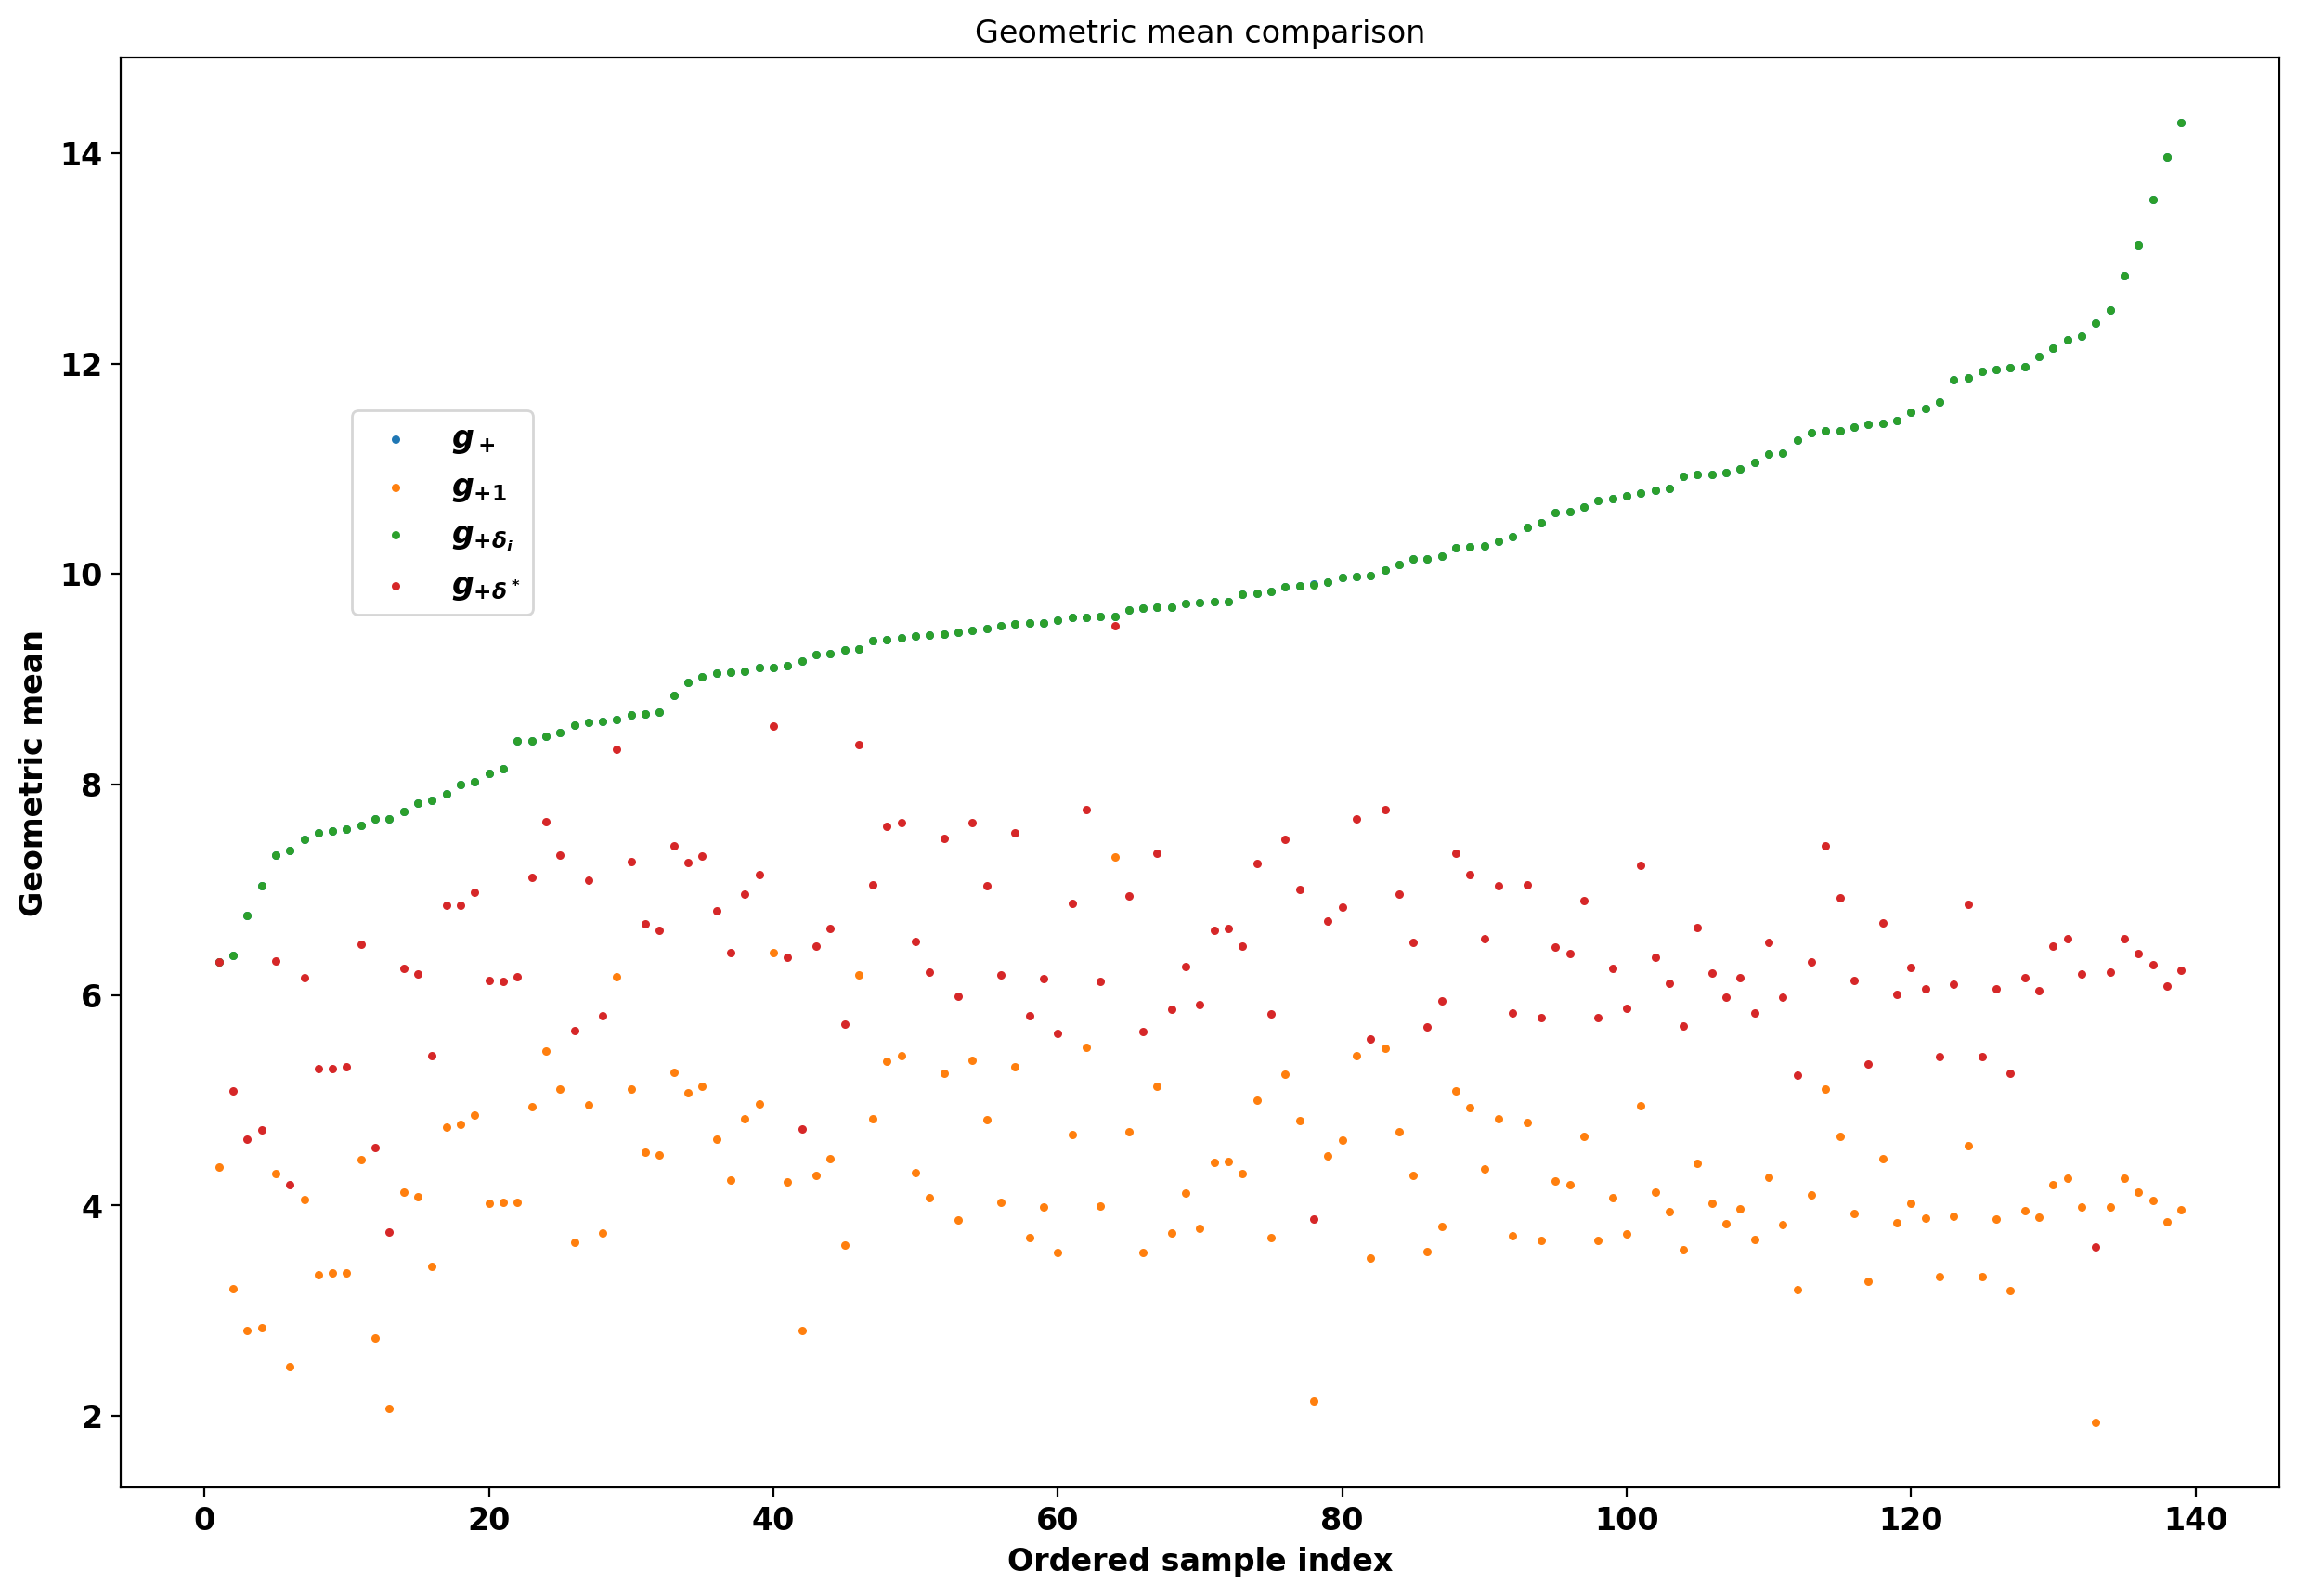

In [ ]:
# Plots to compare the geometric mean of the observed outcome data 
def gpfun(a):
    return np.exp(np.mean(np.log(a[a>0])))
T_p = np.apply_along_axis(gpfun,1,Yo)
T_1 = np.exp(np.mean(np.log(Yo.T+1), axis=0))
T_min = np.exp(np.mean(np.log(Yo.T+delta.min()), axis=0))


fnamex = figfol + 'geometric_mean_compare.pdf'
d_index = T_p.argsort()
d_index1 = 1 + np.arange(T_p.shape[0])
fig, ax = plt.subplots( figsize = (15,10))
ax.scatter(d_index1, T_p[d_index], s = 5)
ax.scatter(d_index1, T_1[d_index], s = 5)
ax.scatter(d_index1, T_i[d_index], s = 5)
ax.scatter(d_index1, T_min[d_index], s = 5)
ax.legend([r'$g_+$', r'$g_{+1}$', r'$g_{+\delta_i}$', r'$g_{+\delta^*}$'], bbox_to_anchor=(0.1, 0.6))
ax.set_title('Geometric mean comparison')
ax.set_ylabel('Geometric mean')
ax.set_xlabel('Ordered sample index')
fig.savefig(fnamex)

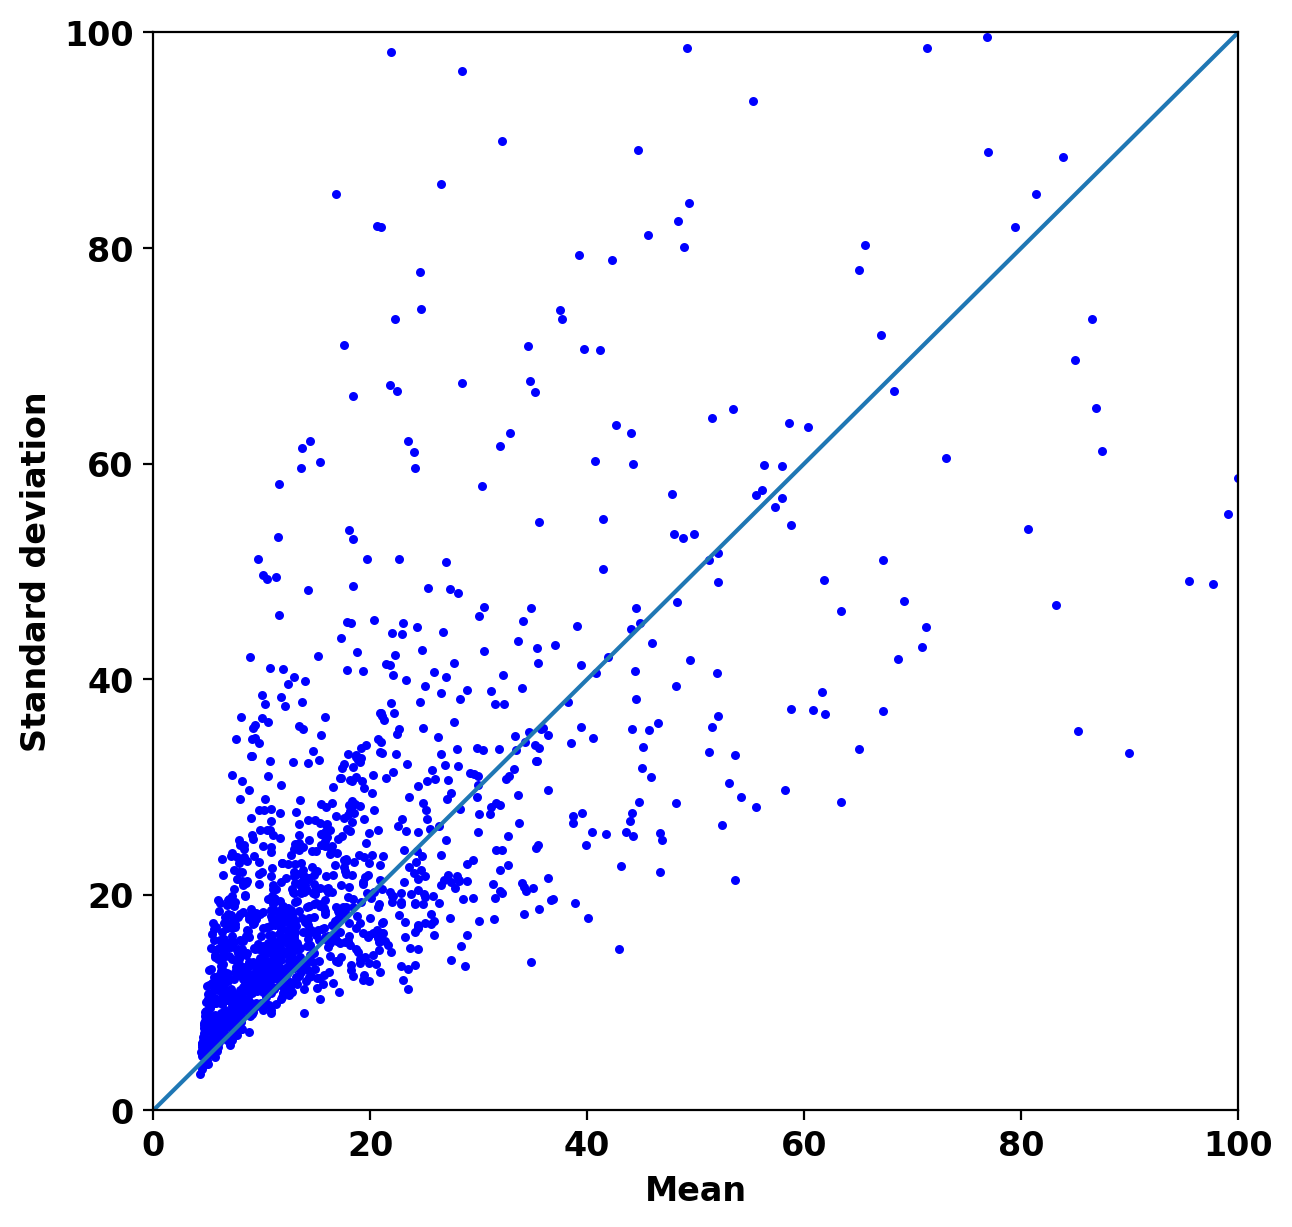

In [3]:
## heatmap of outcome and overdispersion in the data
# Mean and standard deviation of the plot 
fnamex1 = figfol + 'mean_vs_sd.pdf'
a = np.mean(Y, axis = 0)
b = np.std(Y, axis = 0)
fig, ax = plt.subplots( figsize = (7, 7))
ax.scatter(a, b, s = 5, c = 'blue')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel('Mean')
ax.set_ylabel('Standard deviation')
x = np.linspace(0,100)
ax.plot(x, x)
fig.savefig(fnamex1)


### Fitted model validity: Numerical measure

Here we perform the posterior predictive check to validate the parameters estimate. 

In [ ]:
import glob
import pickle
import os
import re

# Define folder path
folname = '../src/'
# original data, no coupling
#fname_best = '18_52_model_nb_cvtest.pkl'
# # NOTE: original data coupling
fname_best = '30_68_model_nb_cvtest.pkl'
# # NOTE: new data, no coupling
#fname_best = 'XXXXXXXXXXXXXXXXXXX.pkl'

# Load fitted model output
with open(os.path.join(folname, fname_best), 'rb') as f:
    [holdout_mask, llpd, n_test, l, m_seed, sp_mean, sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(f)

# Construct filenames using uid and m_seed
fname_ot = os.path.join(folname, f"{uid}_{m_seed}_model_nb.pkl")
sample_fname = os.path.join(folname, f"{uid}_{m_seed}_sample_model_nb_cvtest.pkl")

# Load results
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)

# Load sample model output
with open(sample_fname, 'rb') as f:
    [Yte_sample, Yte_cv] = pickle.load(f)


In [7]:
## Individual value as test statistics
n,q = Y.shape
Y_ppc1 = np.zeros((n,q))
for i in range(n):
    for j in range(q):
        Y_ppc1[i,j] = np.mean(Yte_sample[:,i,j] <= Y[i,j])

## P-valie reported :   0.5221216234559521
np.mean(Y_ppc1)

0.503536613379833

In [8]:
parma_sample  = vbfun.vb_extract_sample(results)
parma_sample  = dict(parma_sample)
print(parma_sample)
parma_mean  = vbfun.vb_extract_mean(results)
parma_mean = dict(parma_mean)
print(parma_mean)
muest = np.zeros((n,q))
muest1 = np.zeros((n,q))

# Initialize arrays
Yte_lpmf = np.zeros((nsample_o, n, q), dtype=np.float64)
mu_sample = np.zeros((nsample_o, n, q), dtype=np.float64)

# Conditional logic based on config
if data == "original" and setting == 1:
    print("Running OLD DATA DIRECT COUPLING")
    for i in range(n):
        for j in range(q):
            muest[i,j] =  parma_mean['C0'][j] + \
                np.matmul(X[i,],parma_mean['C_geo'][j,:]) + \
                np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
                np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
                #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])) + \
            if Yi[i,j] == 1:
                temp = copy.copy(Yi[i,:]);temp[j] = 0;
                muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
                muest[i,j] = muest[i,j] + muest1[i,j];
            muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])
            
## Individual value as test statistics
    Y_ppc2 = np.zeros((n,q))
    for i in range(n):
        for j in range(q):
            Y_ppc2[i,j] = np.nanmean(Yte_lpmf[:,i,j] <= vbfun.neg_binomial_2_lpmf(Y[i,j],\
                muest[i,j],1/np.sqrt(parma_mean['phi'][j])))

    ## P-valie reported :   0.5934413079115808  
    np.nanmean(Y_ppc2)

elif data == "original" and setting == 2:
    print("Running OLD DATA NO DIRECT COUPLING")
    for i in range(n):
        for j in range(q):
            muest[i,j] =  parma_mean['C0'][j] + \
                np.matmul(X[i,],np.matmul(parma_mean['A_geo'],parma_mean['L_sp'][j,:])) + \
                np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
                np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
                #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])); 
            if Yi[i,j] == 1:
                temp = copy.copy(Yi[i,:]);temp[j] = 0;
                muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
                muest[i,j] = muest[i,j] + muest1[i,j];
            muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])
            
## Individual value as test statistics
    Y_ppc2 = np.zeros((n,q))
    for i in range(n):
        for j in range(q):
            Y_ppc2[i,j] = np.nanmean(Yte_lpmf[:,i,j] <= vbfun.neg_binomial_2_lpmf(Y[i,j],\
                muest[i,j],1/np.sqrt(parma_mean['phi'][j])))

    ## P-valie reported :   0.5934413079115808  
    np.nanmean(Y_ppc2)

elif data == "new" and setting == 2:
    print("Running NEW DATA NO DIRECT COUPLING ")
    for i in range(n):
        for j in range(q):
            muest[i,j] =  parma_mean['C0'][j] + \
                np.matmul(X[i,],parma_mean['A_geo'][j,:]) + \
                np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
                np.matmul(D[i,],np.matmul(parma_mean['A_d'],parma_mean['L_sp'][j,:])) + \
                np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
                #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])) + \
            if Yi[i,j] == 1:
                temp = copy.copy(Yi[i,:]);temp[j] = 0;
                muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
                muest[i,j] = muest[i,j] + muest1[i,j];
            muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])
            
## Individual value as test statistics
    Y_ppc2 = np.zeros((n,q))
    for i in range(n):
        for j in range(q):
            Y_ppc2[i,j] = np.nanmean(Yte_lpmf[:,i,j] <= vbfun.neg_binomial_2_lpmf(Y[i,j],\
                muest[i,j],1/np.sqrt(parma_mean['phi'][j])))

    ## P-valie reported :   0.5934413079115808  
    np.nanmean(Y_ppc2)
    

else:
    raise ValueError(f"Combination data={data} and setting={setting} not supported yet.")

# Save and reload
pickle.dump(Yte_lpmf, open('BMSample_lpmf.pkl', 'wb'))
Yte_lpmf = pickle.load(open('BMSample_lpmf.pkl', 'rb'))


../utils/vb_stan.py:25: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])


{'C0': array([[ 2.44239865,  0.84683516,  2.6289167 , ...,  1.87669347,
        -0.7597023 ,  2.37934469],
       [ 2.39383523,  1.03964418,  2.35619272, ...,  2.34713772,
        -0.71201048,  1.89660607],
       [ 1.76028868,  0.73777369,  3.14911121, ...,  0.60649234,
        -1.07137936,  2.45243795],
       ...,
       [ 1.71621798,  0.54760851,  2.73056554, ...,  0.92832564,
        -1.24003591,  1.36869855],
       [ 1.83928424,  0.28662323,  2.85096029, ...,  0.90555543,
        -1.4019275 ,  1.89481094],
       [ 1.83120182, -0.06986008,  2.21479384, ...,  2.32470664,
        -0.68104426,  1.92004623]]), 'C_geo': array([[[-1.77688154e-01,  1.81129288e-02,  3.36359815e-01, ...,
          2.79565126e-02, -6.89855647e-02,  9.60962021e-03],
        [ 1.19145032e-01,  2.26302751e-01,  7.27314821e-02, ...,
         -1.18632382e-01, -1.66670943e-01,  1.36145377e-02],
        [-6.66721539e-03,  3.71273916e-01,  2.64442645e-01, ...,
         -3.96482612e-01, -1.75553975e-01, -5.6700293

../utils/vb_stan.py:57: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty(shape)) for name, shape in param_shapes.items()])


{'C0': array([ 2.11401551,  0.38221769,  2.39425415, ...,  1.55730043,
       -1.03898579,  2.05586453]), 'C_geo': array([[-0.02700285,  0.03017611,  0.0287442 , ..., -0.18116975,
        -0.04612094, -0.00377139],
       [ 0.00381557,  0.17535123,  0.03331577, ..., -0.00241095,
        -0.09755916,  0.03713166],
       [-0.0202873 ,  0.26805362,  0.11931222, ..., -0.29069354,
        -0.04266862, -0.32177046],
       ...,
       [ 0.34205867,  0.05297769, -0.04870143, ..., -0.07060397,
        -0.02442979, -0.00828533],
       [-0.09193309, -0.01854879,  0.08191867, ...,  0.05335357,
        -0.03562191,  0.00657415],
       [ 0.35523306,  0.0567277 ,  0.03435266, ..., -0.10650771,
        -0.0806001 , -0.02396135]]), 'L_sp': array([[-0.11091059,  0.00384859, -0.02019706, ..., -0.30095684,
        -0.04098674,  0.18311648],
       [-0.24799613, -0.01239977, -0.04456707, ..., -0.02621599,
        -0.33122985,  0.17393125],
       [ 0.01747775,  0.00538736, -0.01475368, ..., -0.23319141